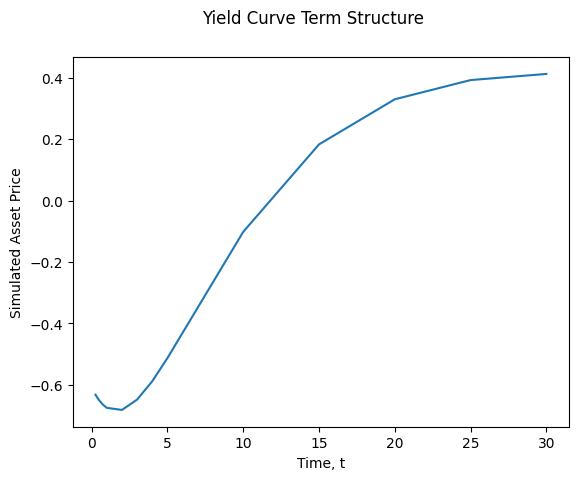

[-0.63171  -0.650322 -0.664493 -0.674608 -0.681294 -0.647593 -0.587828
 -0.51251  -0.101804  0.182851  0.32962   0.392117  0.412151]
[ 0.25  0.5   0.75  1.    2.    3.    4.    5.   10.   15.   20.   25.
 30.  ]


In [1]:
import numpy as np
from PyCurve.curve import Curve
import matplotlib.pyplot as plt

time = np.array([0.25, 0.5, 0.75, 1., 2., 
                 3., 4., 5., 10., 15., 
                 20., 25., 30.])
rate = np.array([-0.63171, -0.650322, -0.664493, -0.674608, -0.681294,
                 -0.647593, -0.587828, -0.51251, -0.101804,  0.182851,
                 0.32962, 0.392117,  0.412151])

curve = Curve(time, rate)

# Custom plot function
def plot_curve(curve_obj):
    fig, ax = plt.subplots(1)
    fig.suptitle("Yield Curve Term Structure")
    fig.canvas.manager.set_window_title('Yield Curve Term Structure')  # Fixed line
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    
    # Access time and rate using the appropriate attributes
    time_data = curve_obj.get_time
    rate_data = curve_obj.get_rate
    
    ax.plot(time_data, rate_data)
    plt.show()

# Use the custom plot function
plot_curve(curve)

# Accessing attributes correctly
print(curve.get_rate)
print(curve.get_time)


In [2]:
from PyCurve import Curve
time = np.array([0.25, 0.5, 0.75, 1., 2., 
        3., 4., 5., 10., 15., 
        20.,25.,30.])
d_rate = np.array([-0.63171, -0.650322, -0.664493, -0.674608, -0.681294,
        -0.647593, -0.587828, -0.51251, -0.101804,  0.182851,
        0.32962,0.392117,  0.412151])
curve = Curve(time,d_rate)

ImportError: cannot import name 'Curve' from 'PyCurve' (c:\Users\tanishk.deoghare\AppData\Local\anaconda3\envs\LMM\Lib\site-packages\PyCurve\__init__.py)

In [3]:
from PyCurve.linear import LinearCurve
linear_curve = LinearCurve(curve)
print("7.5-year d_rate : "+str(linear_curve.d_rate(7.5)))
print("7.5-year discount d_rate : "+str(linear_curve.df_t(7.5)))
print("Forward d_rate between 7.5 and 12.5 years : "+str(linear_curve.forward(7.5,12.5)))

7.5-year d_rate : -0.307157
7.5-year discount d_rate : 1.0233404498400862
Forward d_rate between 7.5 and 12.5 years : 0.5620442499999999


In [4]:
from PyCurve.nelson_siegel import NelsonSiegel
ns = NelsonSiegel(0.3,0.4,12,1)
ns.calibrate(curve)

Nelson Siegel Model
beta0 = 0.7515060771417343
beta1 = -1.3304972091294238
beta2 = -2.2203178638608274
tau = 2.5493057062390716
____________________________
Calibration Results
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Mean Squared Error 0.004236730692646304
Number of Iterations 20
____________________________


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.004236730692646304
        x: [ 7.515e-01 -1.330e+00 -2.220e+00  2.549e+00]
      nit: 20
      jac: [-2.401e-06  9.493e-07 -2.332e-07  7.985e-07]
     nfev: 105
     njev: 21
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [13]:
import QuantLib as ql
today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.01, ql.Actual365Fixed()))

initialValue = ql.QuoteHandle(ql.SimpleQuote(100))
v0 = 0.005
kappa = 0.8
theta = 0.008
rho = 0.2
sigma = 0.1

hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, v0, kappa, theta, sigma, rho)
hestonModel = ql.HestonModel(hestonProcess)

engine = ql.AnalyticHestonEngine(hestonModel)

In [14]:
import QuantLib as ql
import pandas as pd

In [15]:
# Begin by setting the valuation date of which the cap and the floor should be priced at
ql.Settings.instance().evaluationDate = ql.Date(1, 1, 2022)
# Then we initialize the curve we want to use for discounting and forecasting
discount_factors = [1, 0.965, 0.94]  # discount factors
dates = [
    ql.Date(1, 1, 2022),
    ql.Date(1, 1, 2023),
    ql.Date(1, 1, 2024),
]  # maturity dates of the discount factors
day_counter = ql.Actual360()
# Note that we will not strip a curve here, but simply use the discount factors and the dates defined above
# By default QuantLib DiscountCurve will log linearly interpolate between the points.
discount_curve = ql.DiscountCurve(dates, discount_factors, day_counter)
# The curve will note be linked in case we want to update the quotes later on
discount_handle = ql.YieldTermStructureHandle(discount_curve)

In [16]:
start_date = ql.Date(1, 1, 2022)
end_date = start_date + ql.Period(12, ql.Months)

# We define the schedule of the cap and floor
schedule = ql.Schedule(
    start_date,                 # Start date of payments
    end_date,                   # End date of payments
    ql.Period(3, ql.Months),    # frequency of payments
    ql.Sweden(),                # Calendar for adjusting for holidays
    ql.ModifiedFollowing,       # Business convention for adjusting for holidays
    ql.ModifiedFollowing,       # Business convention for adjusting for holidays
    ql.DateGeneration.Backward, # Date generation rule for generating the schedule
    False,                      # End of month rule
)

# Create a custom index to track the payments correctly, specifically fixing days.
custom_discount_index= ql.IborIndex(
    "MyIndex",
    ql.Period("3m"),
    0,
    ql.SEKCurrency(),
    ql.Sweden(),
    ql.ModifiedFollowing,
    False,
    ql.Actual360(),
    discount_handle,
)

In [17]:
# As you have noted by now, the pricing of caps and floors involves creating a floating leg
ibor_leg_discount = ql.IborLeg([1e6], schedule, custom_discount_index)
strike = [0.025]
cap_discount = ql.Cap(ibor_leg_discount, strike)

# The final step is to define a volatility surface, we will use a constant volatility for simplicity
volatility = ql.QuoteHandle(ql.SimpleQuote(0.5))

# Input our discounting and forecasting curve together with our volatility surface to the engine
engine = ql.BlackCapFloorEngine(discount_handle, volatility)
cap_discount.setPricingEngine(engine)
print(cap_discount.NPV())

10831.583434218297


In [18]:
schedule_dates = schedule.dates()

display_result = lambda _ : pd.DataFrame({
    'price': _.optionletsPrice(),
    'discount_factor': _.optionletsDiscountFactor(),
    'cap_rate': _.capRates(),
    'atm_forward': _.optionletsAtmForward(),
    'std_dev': _.optionletsStdDev(),
    'accrual_start': schedule_dates[:-1],
    'accrual_end' : schedule_dates[1:]
})

display_result(cap_discount)

,price,discount_factor,cap_rate,atm_forward,std_dev,accrual_start,accrual_end
0,2493.450264,0.991254,0.025,0.035290,0.037012,"January 3rd, 2022","April 1st, 2022"
1,2625.359083,0.982488,0.025,0.035296,0.248282,"April 1st, 2022","July 1st, 2022"
2,2846.309041,0.973515,0.025,0.035301,0.352097,"July 1st, 2022","October 3rd, 2022"
3,2866.465047,0.964931,0.025,0.035193,0.434000,"October 3rd, 2022","January 2nd, 2023"


In [19]:
ql.Settings.instance().evaluationDate = ql.Date(1, 1, 2022)

# Similiar to the discount curve we declared previously
forward_rates = [0.04, 0.05, 0.06]
forward_curve = ql.ForwardCurve(dates, forward_rates, day_counter)
forward_handle = ql.YieldTermStructureHandle(forward_curve)

In [20]:
# Create a new index that uses the forward curve for forecasting
custom_forward_index= ql.IborIndex(
    "MyIndex",
    ql.Period("3m"),
    0,
    ql.SEKCurrency(),
    ql.Sweden(),
    ql.ModifiedFollowing,
    False,
    ql.Actual360(),
    forward_handle, # Previously was set to discount_handle
)

In [22]:
# Define a new ibor_leg & cap that uses the new index with forward estimation
ibor_leg_forward = ql.IborLeg([1e6], schedule, custom_forward_index)
cap_forward = ql.Cap(ibor_leg_forward, strike)

# Input our discounting and forecasting curve together with our volatility surface to the engine
engine_forward = ql.BlackCapFloorEngine(discount_handle, volatility)
cap_forward.setPricingEngine(engine_forward)
print(cap_forward.NPV())

25171.79621353972


In [23]:
schedule_dates = schedule.dates()
display_result(cap_forward)

,price,discount_factor,cap_rate,atm_forward,std_dev,accrual_start,accrual_end
0,6132.002083,0.991254,0.025,0.050307,0.037012,"January 3rd, 2022","April 1st, 2022"
1,6289.142138,0.982488,0.025,0.050317,0.248282,"April 1st, 2022","July 1st, 2022"
2,6465.774497,0.973515,0.025,0.050328,0.352097,"July 1st, 2022","October 3rd, 2022"
3,6284.877495,0.964931,0.025,0.050429,0.434000,"October 3rd, 2022","January 2nd, 2023"


In [24]:
# Set the settlement day of the volatility surface
settlementDays = 0

# Define the expiries for the volatility surface
expiries = [ql.Period("3M"), ql.Period("6M"), ql.Period("9M"), ql.Period("1Y")]

# Define the strikes for the volatility surface
strikes = [0.010, 0.025, 0.03]

# Define the market quotes for the volatility surface
black_volatility = [[0.98, 0.792, 0.6873], [0.9301, 0.7401, 0.6403], [0.7926, 0.6424, 0.5602], [0.7126, 0.6024, 0.4902]]

# Create a new volatility surface
volatility_surface = ql.CapFloorTermVolSurface(
    settlementDays,
    ql.Sweden(),
    ql.ModifiedFollowing,
    expiries,
    strikes,
    black_volatility,
    day_counter,
)
# Strip the volatility surface for optionlets (caplets) as the input is based on caps
optionlet_surf = ql.OptionletStripper1(volatility_surface, custom_forward_index)

# Call strippedOptionletAdapter to create a handle for the volatility surface
ovs_handle = ql.OptionletVolatilityStructureHandle(
    ql.StrippedOptionletAdapter(optionlet_surf)
)

cap_volatility = ql.Cap(ibor_leg_forward, strike)
# Input our discounting and forecasting curve together with our volatility surface to the engine
engine_volatility = ql.BlackCapFloorEngine(discount_handle, ovs_handle)
cap_volatility.setPricingEngine(engine_volatility)
print(cap_volatility.NPV())

25340.288918668186


In [25]:
display_result(cap_volatility)

,price,discount_factor,cap_rate,atm_forward,std_dev,accrual_start,accrual_end
0,6132.002083,0.991254,0.025,0.050307,0.000000,"January 3rd, 2022","April 1st, 2022"
1,6325.268247,0.982488,0.025,0.050317,0.372127,"April 1st, 2022","July 1st, 2022"
2,6526.008974,0.973515,0.025,0.050328,0.434983,"July 1st, 2022","October 3rd, 2022"
3,6357.009614,0.964931,0.025,0.050429,0.500385,"October 3rd, 2022","January 2nd, 2023"


In [26]:
ql.IborIndex('MyIndex', ql.Period('6m'), 2, ql.EURCurrency(), ql.TARGET(), ql.ModifiedFollowing, True, ql.Actual360())
ql.Libor('MyIndex', ql.Period('6M'), 2, ql.USDCurrency(), ql.TARGET(), ql.Actual360())
ql.Euribor(ql.Period('6M'))
ql.USDLibor(ql.Period('6M'))
ql.Euribor6M()

<QuantLib.QuantLib.Euribor6M; proxy of <Swig Object of type 'ext::shared_ptr< Euribor6M > *' at 0x000001596890F840> >

In [28]:
today = ql.Date().todaysDate()
calendar = ql.NullCalendar()
dayCounter = ql.Actual365Fixed()
volatility = 0.2
r, q = 0.02, 0.05

blackVolTs = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, volatility, dayCounter))
ratesTs = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dayCounter))
dividendTs = ql.YieldTermStructureHandle(ql.FlatForward(today, q, dayCounter))
spot = 100

ql.LocalVolSurface(blackVolTs, ratesTs, dividendTs, spot)

<QuantLib.QuantLib.LocalVolSurface; proxy of <Swig Object of type 'ext::shared_ptr< LocalVolSurface > *' at 0x000001594D399530> >

In [30]:
import QuantLib as ql
import matplotlib.pyplot as plt

In [37]:
dates = [ql.Date(15,6,2020), ql.Date(15,6,2021), ql.Date(15,6,2022)]
zeros = [0.01, 0.02, 0.03]
curve = ql.ZeroCurve(dates, zeros, ql.ActualActual, ql.TARGET())

TypeError: Wrong number or type of arguments for overloaded function 'new_ZeroCurve'.
  Possible C/C++ prototypes are:
    InterpolatedZeroCurve< Linear >::InterpolatedZeroCurve(std::vector< Date,std::allocator< Date > > const &,std::vector< Rate,std::allocator< Rate > > const &,DayCounter const &,Calendar const &,Linear const &,Compounding,Frequency)
    InterpolatedZeroCurve< Linear >::InterpolatedZeroCurve(std::vector< Date,std::allocator< Date > > const &,std::vector< Rate,std::allocator< Rate > > const &,DayCounter const &,Calendar const &,Linear const &,Compounding)
    InterpolatedZeroCurve< Linear >::InterpolatedZeroCurve(std::vector< Date,std::allocator< Date > > const &,std::vector< Rate,std::allocator< Rate > > const &,DayCounter const &,Calendar const &,Linear const &)
    InterpolatedZeroCurve< Linear >::InterpolatedZeroCurve(std::vector< Date,std::allocator< Date > > const &,std::vector< Rate,std::allocator< Rate > > const &,DayCounter const &,Calendar const &)
    InterpolatedZeroCurve< Linear >::InterpolatedZeroCurve(std::vector< Date,std::allocator< Date > > const &,std::vector< Rate,std::allocator< Rate > > const &,DayCounter const &)
